In [1]:
## all imports
from IPython.display import HTML
import chardet
import io
import numpy as np
np.seterr(divide='ignore', invalid='ignore')
import os
import urllib.request
from urllib.request import urlopen
from bs4 import BeautifulSoup
from time import sleep
import requests
import operator
import socket
import _pickle
import math
import re # regular expressions

from pandas import Series
import pandas as pd
from pandas import DataFrame

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)
import json

import seaborn as sns
sns.set_context("talk")
sns.set_style("white")

from selenium import webdriver
from selenium.webdriver.support.ui import Select
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC



#from secret import *

## WRITING THE FILES

### Firefox Driver

In [8]:
wd = webdriver.Firefox()
#driver.implicitly_wait(10)
wd.get('http://www.afl.com.au/stats')

### FUNCTION THAT PASSES IN YEAR AND ROUND AND DOWNLOADS JSON FILE

In [9]:
def data_download (_year,_round):
    movable_part = "CD_S{year}014&roundId=CD_R{year}014{round}".format(year=_year, round= _round)
    #print(movable_part)
    script = '' + \
    'window.a = jQuery.ajax({'+\
    '        url:"http://www.afl.com.au/api/cfs/afl/statsCentre/teams?competitionId={}",'.format(movable_part) +\
    '        headers: {'+\
    '                    "X-media-mis-token":"b292a40a7cfcbe808732a7ce5aa62114"'+\
    '                 }'+\
    '        });' 

    ## asks the firefox webdriver to execute this scripty
    #print (script)
    wd.execute_script(script)
    print (_year, _round)
    import time
    import json
    time.sleep(1)
    wd.execute_script("console.log('the dude', window.a.responseText);")
    result = wd.execute_script("return window.a.responseText")
    
    try:
        data = json.loads(result)
        filename= _year  + '_' + _round + '.txt'
        #with open('afl_raw/' + filename, 'w') as f:
        with open ('afl_raw/test/' + filename, 'w') as f:
            f.write(result)
            print ('exported ' + filename)
        
    except Exception as e:
        filename= _year  + '_' + _round + '.txt'
        #ith open('afl_raw/' + filename, 'w') as f:
        with open('afl_raw/test/' + filename, 'w') as f:
            f.write('error occured on writing')
            print ('export error on ' + filename)
        

            

    

### HARD CODED JQUERY TO PUT INTO CONSOLE

jQuery.ajax({url:"http://www.afl.com.au/api/cfs/afl/statsCentre/teams?competitionId=CD_S2017014&roundId=CD_R201701406", headers: {"X-media-mis-token":"b0e22835816435c8436393d14e62ecf7"}});

jQuery.ajax({url:" http://www.afl.com.au/api/cfs/afl/statsCentre/teams?competitionId=CD_S2003014&roundId=CD_R200301401", headers: {"X-media-mis-token":"b0e22835816435c8436393d14e62ecf7"}});

### LIST OF POSSIBLE YEARS AND ROUNDS FOR DATA

In [10]:
year_list = ['2017','2016','2015','2014','2013','2012','2011','2010','2009','2008','2007','2006','2005','2004','2003','2002', '2001']
round_list = ['01','02','03','04','05','06','07','08','09','10','11','12','13','14','15','16','17','18','19','20','21','22','23','24','25','26','27']

### RUN A LOOP OVER ALL ROUNDS IN ALL YEARS TO INITIATE THE DOWNLOAD FUNCTION

In [11]:
for i in year_list:
    current_year = i
    for i in round_list:
        current_round = i
        data_download(current_year,current_round)

2017 01
export error on 2017_01.txt
2017 02
export error on 2017_02.txt
2017 03
export error on 2017_03.txt
2017 04
export error on 2017_04.txt
2017 05
export error on 2017_05.txt
2017 06
export error on 2017_06.txt
2017 07


NoSuchWindowException: Message: Unable to locate window


### TESTING INDIVIDUAL DOWNLOADS

current_year = '2005'
current_round = '05'

data_download(current_year,current_round)

## LOAD FILES IN PYTHON

### CREATE DICTIONARY FOR MATCH ID'S

In [ ]:
match_dict= {0:'01',1:'01',2:'02',3:'02', 4:'03',5:'03', 6:'04',7:'04',8:'05',9:'05', 10:'06',11:'06',12:'07',13:'07', 14:'08',15:'08', 16:'09',17:'09'}
print (match_dict[3])

### MERGING TWO DICTIONARIES AND ADDING TO DATAFRAME

a = {"b":1, "c": 2}

d = {"b":3, "c": 2}

x = [a,d]

pd.DataFrame(x)



z = {**x, **y}
http://stackoverflow.com/questions/38987/how-to-merge-two-python-dictionaries-in-a-single-expression

### FUNCTION TO LOOK AT EACH MATCH, SORT AND  ASSIGN A MATCH_ID

In [ ]:
def structure_data(d, i, _year, _round):
    team_stats= d['team']
    match_stats = d['stats']['totals']
    # ** merges two dictionaries together
    stats = {**team_stats, **match_stats}
    stats['year'] = _year
    stats['round'] = _round
    # Finding match_id
    #string formatting mini lanuage
    match_dict= {0:'01',1:'01',2:'02',3:'02', 4:'03',5:'03', 6:'04',7:'04',8:'05',9:'05', 10:'06',11:'06',12:'07',13:'07', 14:'08',15:'08', 16:'09',17:'09'}
    #match_number = "{0:0=2d}".format(int(math.ceil(i/2)*2))
    match_number = (match_dict[i])
    stats['match_id'] = 'CD_M' + _year + '014'+  _round + str(match_number)
    #CD_M20170140401
    # W know home is the evan numbers in the list- so if there is no remainder when divived by two its divisible by 2
    stats['home'] = i % 2 == 0
    stats = {**stats, **stats['clearances']}
    stats.pop('clearances', None)
    #try:
        #stats = {**stats, **stats['interchangeCounts']}
        #stats.pop('interchangeCounts', None)
   #except:
        #print (stats)
        # interchange counts are equal to zero
    return stats

### FUNCTION TO READ EACH DATA FILE- RETURNS A RELEVENT LIST OF ROUNDS GAMES

In [ ]:
def readfile(_year, _round):
    filename= _year  + '_' + _round + '.txt'
    path = 'afl_raw/' + filename
    print (current_year, current_round, path)
    with open(path) as f:
        json_string = f.read()
        json_string = json_string.strip()
        if json_string != "error occured on writing":
            data = json.loads(json_string)
            this_round = []
            for i, d in enumerate(data['lists']):
                stats = structure_data(d, i,_year, _round)
                this_round.append(stats)
            return this_round

### CALL ALL THE ROUND DATA AND ADD TO A BIG LIST OF DICTIONARES

In [ ]:
mega_list = []
for current_year in year_list:
    for current_round in round_list:
        data = readfile(current_year, current_round)
        if data:
            try:
                mega_list.extend(data)
            except Exception as e:
                print(e, data)
            #print (current_year)
        #except Exception as e:
            #print (e)


### CREATE SERIES OF MATCHING DICTIONARIES WITHIN A LIST TO CREATE A DATAFRAME- USE ANY CLEAN SCRAPES

In [ ]:
print (mega_list)

### ADD DATA LIST INTO DATA FRAME

In [ ]:
df = pd.DataFrame(mega_list)
print (df.shape)
df.head(300)
df.shape

### SEE DATA TYPES

In [ ]:
df.dtypes

### ASSIGN OPPONENT- LIST TECHNIQUE

grades = []

for index, row in df.iterrows():
    current_name = row['teamName']
    current_match = row['match_id']
    print  (current_name)
    for index_, row_ in df.iterrows():
        if (row_['match_id'] == current_match) & (row_['teamName'] != current_name):
            opponent = row_['teamName']
            grades.append(opponent)
            print (opponent)
            

df['opponent'] = grades

### ASSIGN OPPONENT- VECTORISED TECHNIQUE

In [ ]:
def opponent_(x):
    game_pair = df[df.match_id == x.match_id]
    other_team = game_pair[game_pair.teamName != x.teamName]
    return list(other_team.teamName)[0]

In [ ]:
df['Opponent']= df.apply(opponent_, axis =1)

### TOTAL SCORE

In [ ]:
def total_(x):
    total_score = x.behinds + ((x.goals)*6)                   
    return total_score

In [ ]:
df['total_score']= df.apply(total_, axis =1)

### ASSIGN WIN OR LOSS- VECTORISED TECHNIQUE

In [ ]:
def win_(x):
    x_score = x.total_score
    #Pair up with same match id
    game_pair = df[x.match_id == df.match_id]
    # Find the other team
    other_team = game_pair[game_pair.teamName != x.teamName]
    # Find other team score
    other_score = list(other_team.total_score)[0]
    #return (other_score)
    if x_score > other_score:
        return 'Win'
    elif x_score == other_score:
        return 'Draw'
    else: 
        return "Lose"

In [ ]:
df['Result']= df.apply(win_, axis =1)

### COLUMN HEADERS CAPITALISED

In [ ]:
df.columns = map(str.upper, df.columns)

### TEST IN HEAD

In [ ]:
df.head()
df.shape

### TEST A SPECPIFIC ROWS RESULT

df.loc[0].total_score

### EXPORTING TO CSV (Create stable copy for web)

In [ ]:
df.to_csv("afl_data_set_0.csv")

## WORK WITH STABLE CSV

### LOAD DATA FROM SYSTEM OR WEB

In [5]:
if os.path.isfile("afl_data_set_0.csv"):
    filepath = "afl_data_set_0.csv"
    print ("loading from file")
    
else:
    filepath = "https://docs.google.com/spreadsheets/d/1pfiz1CjeaS36L5CZIGqcXByj9qGpxKztXcsQ8o-1rOQ/pub?output=csv"
    print ("loading from the internet")



NameError: name 'os' is not defined

### READ CSV FILE

In [4]:
df = pd.read_csv(filepath)
print ("done")

NameError: name 'pd' is not defined

### TEST DATAFRAME

In [4]:
df.head()
#df.shape

,Unnamed: 0,BEHINDS,BOUNCES,CENTRECLEARANCES,CLANGERS,CONTESTEDMARKS,CONTESTEDPOSSESSIONS,DISPOSALEFFICIENCY,DISPOSALS,DREAMTEAMPOINTS,...,TEAMNAME,TEAMNICKNAME,TOTALCLEARANCES,TOTALPOSSESSIONS,TURNOVERS,UNCONTESTEDPOSSESSIONS,YEAR,OPPONENT,TOTAL_SCORE,RESULT
0,0,5,8,19,49,14,138,73.6,348,1604,...,Carlton,Blues,38,341,81.0,203,2017,Richmond,89,Lose
1,1,12,3,16,55,11,149,79.0,352,1551,...,Richmond,Tigers,40,354,68.0,205,2017,Carlton,132,Win
2,2,14,2,16,45,12,161,74.5,431,1835,...,Collingwood,Magpies,42,437,70.0,276,2017,Western Bulldogs,86,Lose
3,3,10,3,10,44,12,135,77.0,392,1774,...,Western Bulldogs,Bulldogs,26,394,63.0,259,2017,Collingwood,100,Win
4,4,12,6,14,51,9,139,69.7,337,1341,...,St Kilda,Saints,31,338,62.0,199,2017,Melbourne,90,Lose


## CREATE TOTALS DATAFRAME

### GROUPBY MATCH_ID TO FIND PERCENTAGES BY GAME

In [30]:
match_totals = df[["TACKLES", "CONTESTEDPOSSESSIONS", "TOTAL_SCORE", "TOTALPOSSESSIONS", "INSIDE50S", "DISPOSALEFFICIENCY", "CENTRECLEARANCES" ]].groupby(df.MATCH_ID).sum()

### ADD MATCH_ID's TO WITHIN DATAFRAME

In [31]:
match_totals["MATCH_ID"] = match_totals.index.values

In [32]:
match_totals.head(3000)

,TACKLES,CONTESTEDPOSSESSIONS,TOTAL_SCORE,TOTALPOSSESSIONS,INSIDE50S,DISPOSALEFFICIENCY,CENTRECLEARANCES,MATCH_ID
MATCH_ID,,,,,,,,
CD_M20010140101,64,268,207,630,99,160.7,33,CD_M20010140101
CD_M20010140102,52,234,166,634,112,163.3,27,CD_M20010140102
CD_M20010140103,62,326,237,670,105,166.1,37,CD_M20010140103
CD_M20010140104,74,235,219,527,104,156.5,32,CD_M20010140104
CD_M20010140105,43,250,192,556,94,160.9,25,CD_M20010140105
CD_M20010140106,72,264,164,659,103,157.0,24,CD_M20010140106
CD_M20010140107,75,248,237,563,99,155.6,34,CD_M20010140107
CD_M20010140108,43,220,200,592,105,163.0,29,CD_M20010140108
CD_M20010140201,75,243,252,551,109,166.5,38,CD_M20010140201


## ADD PERCENTAGES TO MAIN DF

### WORK ACROSS DATA FROM BOTH DATAFRAMES +  DEFINE PERCENTAGES FOR EACH ROW

In [33]:
def TACKLES_percentage(x):
    current_match_id = x.MATCH_ID
    total_row = match_totals.loc[current_match_id]
    total_row_output = total_row.TACKLES
    percentage = (x.TACKLES/ total_row_output)*100
    return float(("%.2f" % round(percentage,2)))

In [34]:
def CONTESTEDPOSSESSIONS_percentage(x):
    current_match_id = x.MATCH_ID
    total_row = match_totals.loc[current_match_id]
    total_row_output = total_row.CONTESTEDPOSSESSIONS
    percentage = (x.CONTESTEDPOSSESSIONS/ total_row_output)*100
    return float(("%.2f" % round(percentage,2)))

In [36]:
def TOTALPOSSESSIONS_percentage(x):
    current_match_id = x.MATCH_ID
    total_row = match_totals.loc[current_match_id]
    total_row_output = total_row.TOTALPOSSESSIONS
    percentage = (x.TOTALPOSSESSIONS/ total_row_output)*100
    return float(("%.2f" % round(percentage,2)))

In [35]:
def INSIDE50S_percentage(x):
    current_match_id = x.MATCH_ID
    total_row = match_totals.loc[current_match_id]
    total_row_output = total_row.INSIDE50S
    percentage = (x.INSIDE50S/ total_row_output)*100
    return float(("%.2f" % round(percentage,2)))

In [37]:
def DISPOSALEFFICIENCY_percentage(x):
    current_match_id = x.MATCH_ID
    total_row = match_totals.loc[current_match_id]
    total_row_output = total_row.DISPOSALEFFICIENCY
    percentage = (x.DISPOSALEFFICIENCY/ total_row_output)*100
    return float(("%.2f" % round(percentage,2)))

In [38]:
def CENTRECLEARANCES_percentage(x):
    current_match_id = x.MATCH_ID
    total_row = match_totals.loc[current_match_id]
    total_row_output = total_row.CENTRECLEARANCES
    percentage = (x.CENTRECLEARANCES/ total_row_output)*100
    return float(("%.2f" % round(percentage,2)))

### RUN PERCENTAGE FUNCTIONS

In [39]:
df["TACKLES_PERC"] = df.apply(TACKLES_percentage, axis=1)
df["CONTESTEDPOSSESSIONS_PERC"] = df.apply(CONTESTEDPOSSESSIONS_percentage, axis=1)
df["TOTALPOSSESSIONS_PERC"] = df.apply(TOTALPOSSESSIONS_percentage, axis=1)
df["INSIDE50S_PERC"] = df.apply(INSIDE50S_percentage, axis=1)
df["DISPOSALEFFICIENCY_PERC"] = df.apply(DISPOSALEFFICIENCY_percentage, axis=1)
df["CENTRECLEARANCES_PERC"] = df.apply(CENTRECLEARANCES_percentage, axis=1)

### REVIEW PERCENTAGES HEAD

In [40]:
df.head()

,Unnamed: 0,BEHINDS,BOUNCES,CENTRECLEARANCES,CLANGERS,CONTESTEDMARKS,CONTESTEDPOSSESSIONS,DISPOSALEFFICIENCY,DISPOSALS,DREAMTEAMPOINTS,...,YEAR,OPPONENT,TOTAL_SCORE,RESULT,TACKLES_PERC,CONTESTEDPOSSESSIONS_PERC,TOTALPOSSESSIONS_PERC,INSIDE50S_PERC,DISPOSALEFFICIENCY_PERC,CENTRECLEARANCES_PERC
0,0,5,8,19,49,14,138,73.6,348,1604,...,2017,Richmond,89,Lose,43.51,48.08,49.06,44.04,48.23,54.29
1,1,12,3,16,55,11,149,79.0,352,1551,...,2017,Carlton,132,Win,56.49,51.92,50.94,55.96,51.77,45.71
2,2,14,2,16,45,12,161,74.5,431,1835,...,2017,Western Bulldogs,86,Lose,43.51,54.39,52.59,58.49,49.17,61.54
3,3,10,3,10,44,12,135,77.0,392,1774,...,2017,Collingwood,100,Win,56.49,45.61,47.41,41.51,50.83,38.46
4,4,12,6,14,51,9,139,69.7,337,1341,...,2017,Melbourne,90,Lose,46.49,48.60,42.73,43.88,47.35,42.42


### FLIP THE INDEX

In [41]:
match_totals_flip = match_totals.reindex(index=match_totals.index[::-1])

### ADD A SEQUENTIAL NUMBER COLUMN

In [42]:
match_totals_flip.insert(0, 'New_ID_', range(0, 0 + len(match_totals)))
match_totals_flip

,New_ID_,TACKLES,CONTESTEDPOSSESSIONS,TOTAL_SCORE,TOTALPOSSESSIONS,INSIDE50S,DISPOSALEFFICIENCY,CENTRECLEARANCES,MATCH_ID
MATCH_ID,,,,,,,,,
CD_M20170140709,0,105,252,195,753,97,154.2,30,CD_M20170140709
CD_M20170140708,1,166,281,185,785,102,152.9,26,CD_M20170140708
CD_M20170140707,2,110,257,216,728,102,144.4,29,CD_M20170140707
CD_M20170140706,3,141,293,155,767,109,151.6,23,CD_M20170140706
CD_M20170140705,4,141,296,223,811,119,147.7,32,CD_M20170140705
CD_M20170140704,5,120,302,184,776,107,146.8,27,CD_M20170140704
CD_M20170140703,6,150,274,135,702,86,147.4,17,CD_M20170140703
CD_M20170140702,7,140,329,231,783,135,139.0,34,CD_M20170140702
CD_M20170140701,8,165,298,193,783,103,146.4,27,CD_M20170140701


## ANALYSE

### DRAW GRAPHS IN THE NOTEBOOK

In [49]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (20, 10)

In [50]:
df_win = df[df.RESULT == "Win"]

In [51]:
df_lose = df[df.RESULT == "Lose"]

#### TOTAL TACKLES OVER TIME

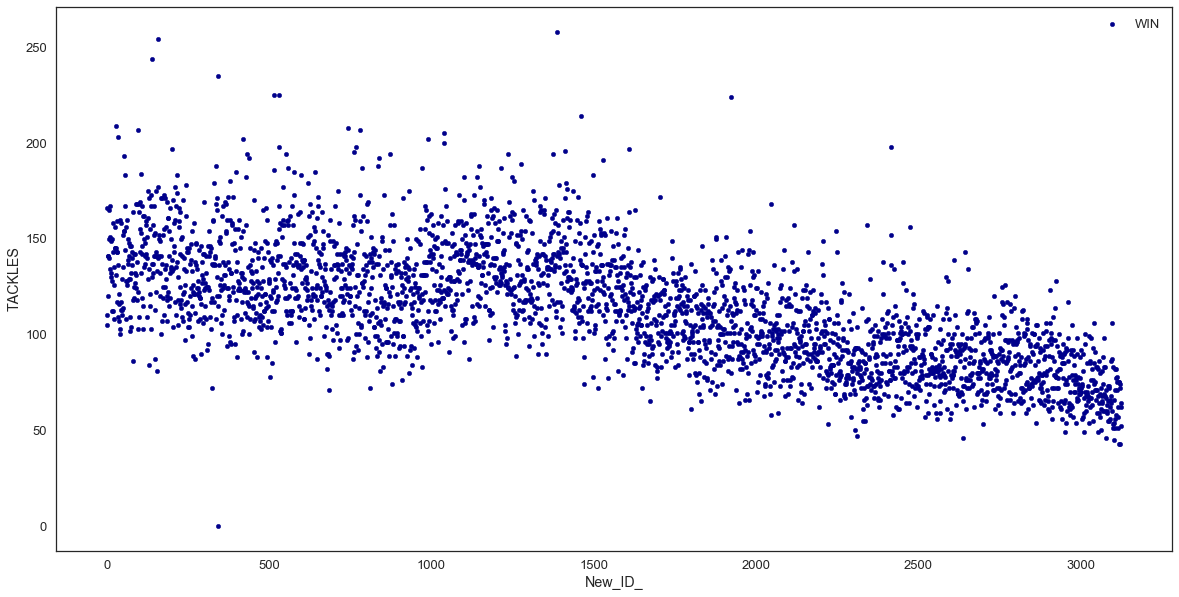

In [52]:
ax = match_totals_flip.plot(kind='scatter', x='New_ID_', y='TACKLES', color='DarkBlue', label='WIN' );


#### TOTAL TACKLES OVER TIME(WIN V LOSS)

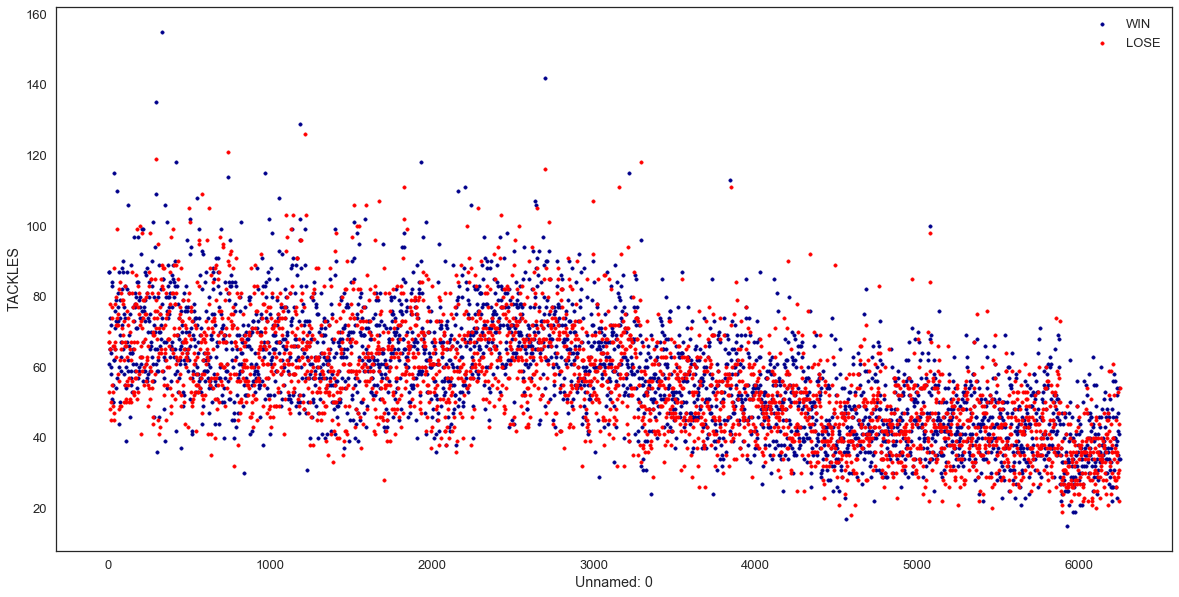

In [85]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TACKLES", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="TACKLES", s=12, color='Red', label='LOSE', ax=ax);

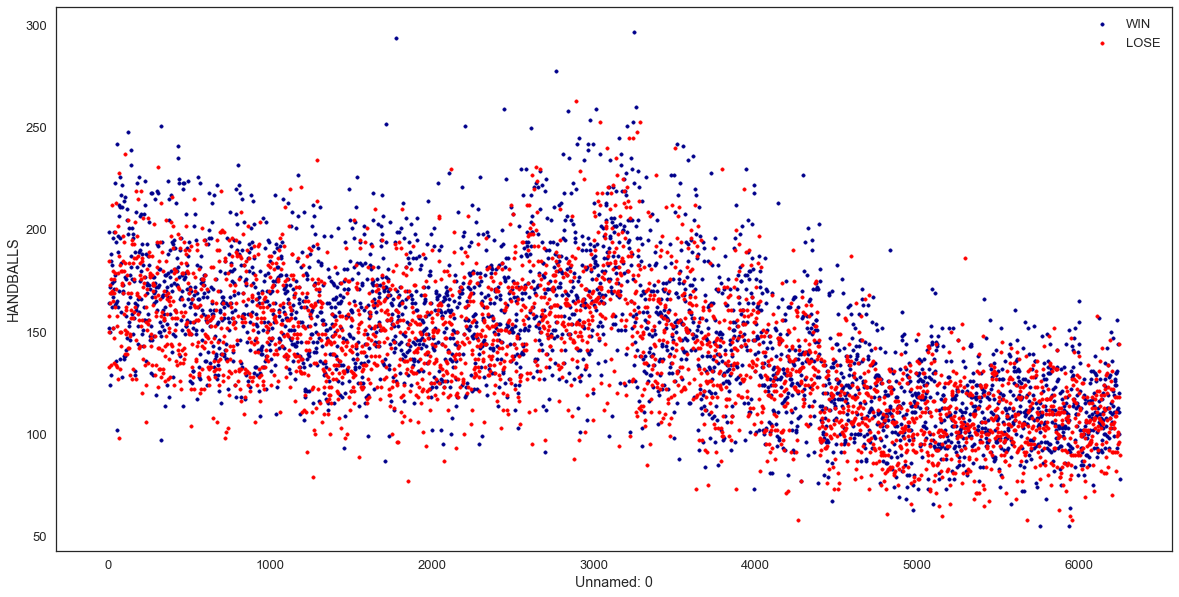

In [95]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="HANDBALLS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="HANDBALLS", s=12, color='Red', label='LOSE', ax=ax);

http://pandas.pydata.org/pandas-docs/version/0.15.0/visualization.html

#### TACKLE SHARE BY GAME OVER TIME(WIN V LOSS)

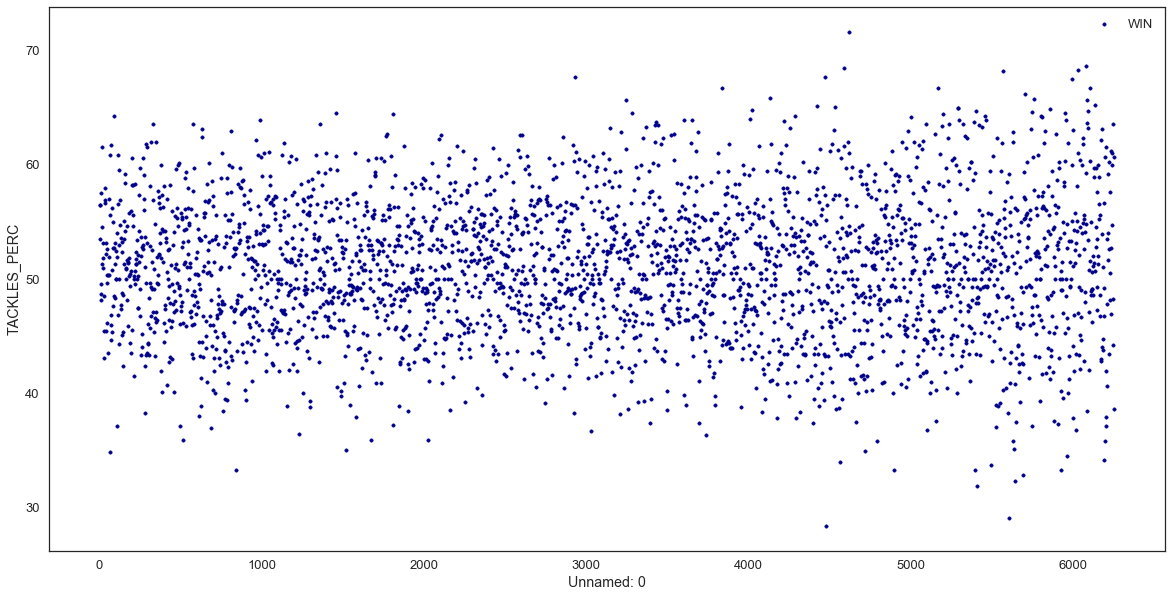

In [105]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TACKLES_PERC", s=12, color='DarkBlue', label='WIN' );

#df_lose.plot(kind='scatter', x='Unnamed: 0', y="TACKLES_PERC", s=12, color='Red', label='LOSE', ax=ax);

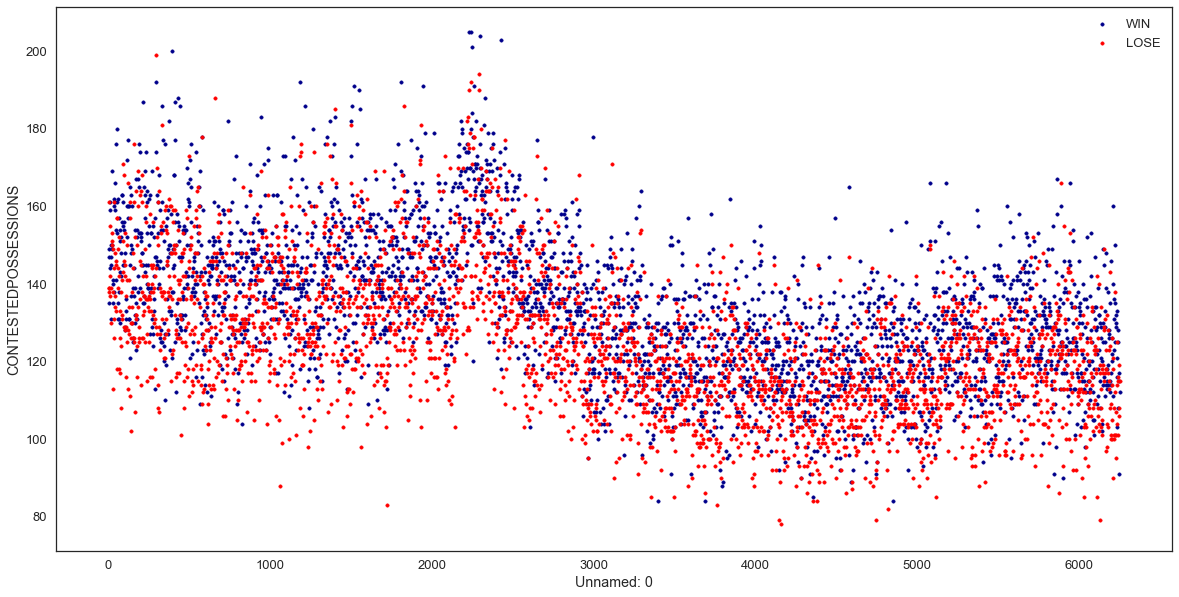

In [82]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS", s=12, color='Red', label='LOSE', ax=ax);

ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS_PERC", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS_PERC", s=12, color='Red', label='LOSE', ax=ax);

In [90]:
df.dtypes

Unnamed: 0                     int64
BEHINDS                        int64
BOUNCES                        int64
CENTRECLEARANCES               int64
CLANGERS                       int64
CONTESTEDMARKS                 int64
CONTESTEDPOSSESSIONS           int64
DISPOSALEFFICIENCY           float64
DISPOSALS                      int64
DREAMTEAMPOINTS                int64
FREESAGAINST                   int64
FREESFOR                       int64
GOALACCURACY                 float64
GOALASSISTS                    int64
GOALEFFICIENCY               float64
GOALS                          int64
HANDBALLS                      int64
HITOUTS                        int64
HOME                            bool
INSIDE50S                      int64
INTERCEPTS                   float64
INTERCHANGECOUNTS             object
KICKS                          int64
LASTUPDATED                   object
MARKS                          int64
MARKSINSIDE50                  int64
MATCH_ID                      object
M

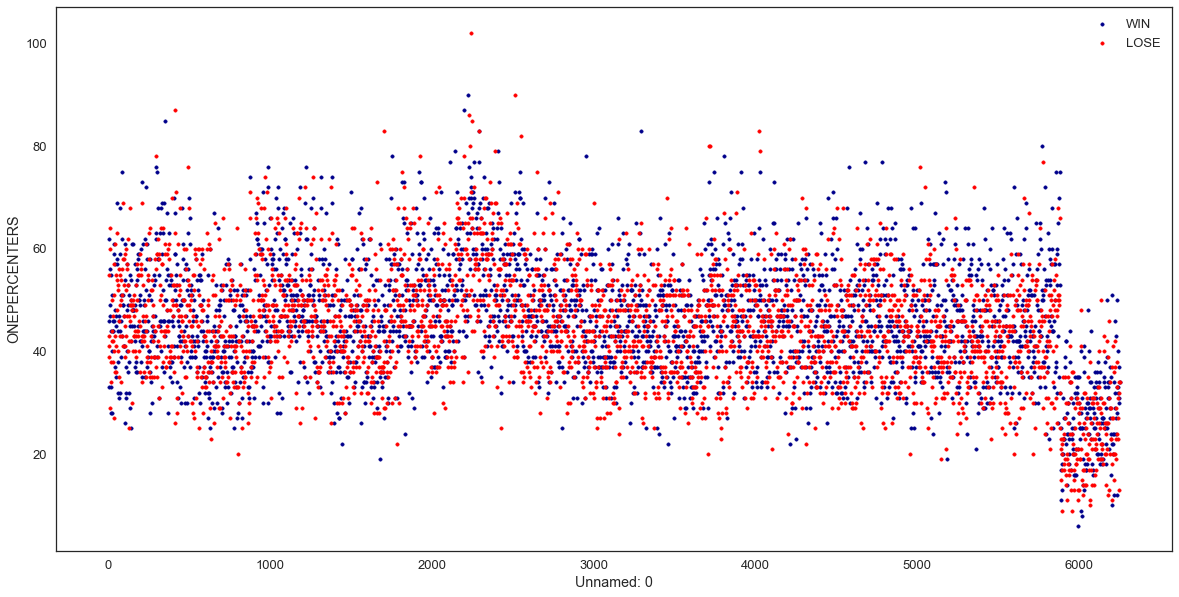

In [112]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="ONEPERCENTERS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="ONEPERCENTERS", s=12, color='Red', label='LOSE', ax=ax);

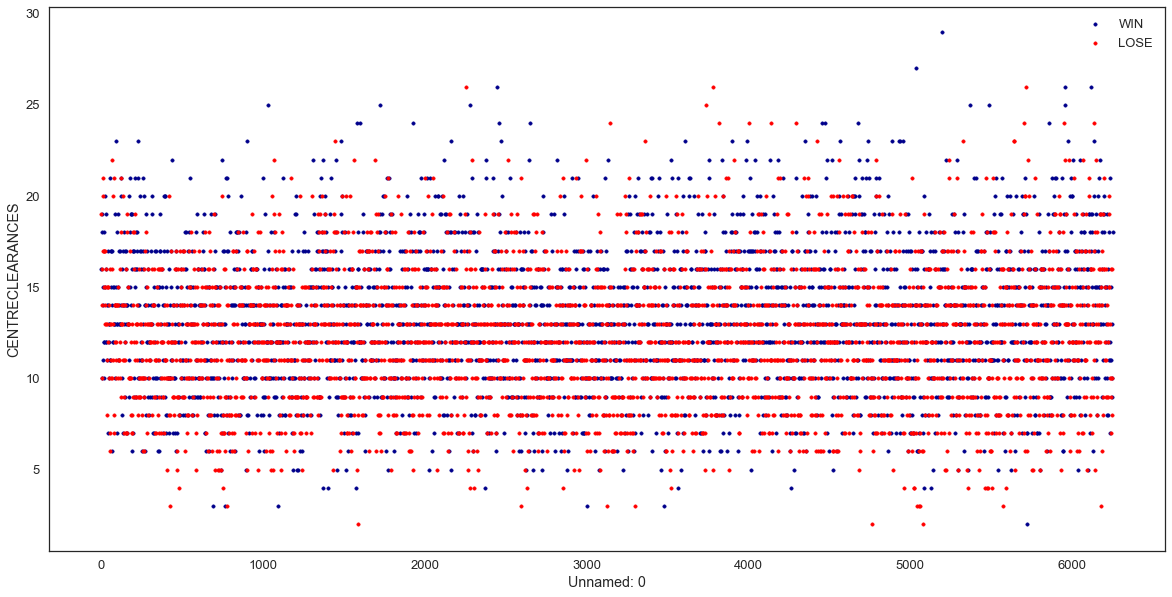

In [122]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="CENTRECLEARANCES", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="CENTRECLEARANCES", s=12, color='Red', label='LOSE', ax=ax);

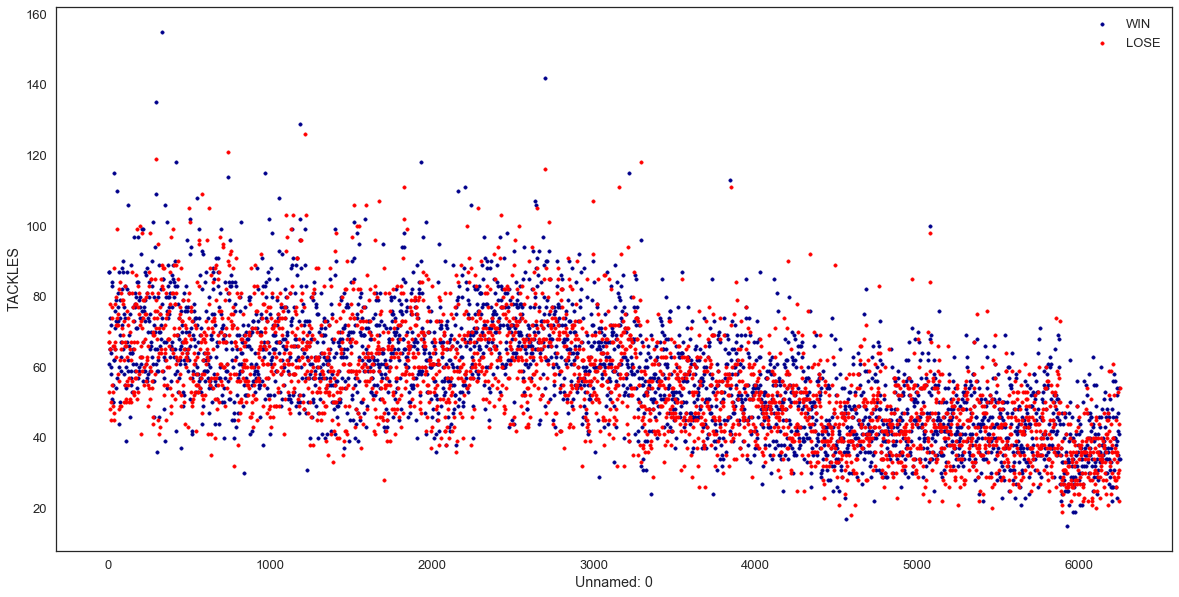

In [126]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TACKLES", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="TACKLES", s=12, color='Red', label='LOSE', ax=ax);

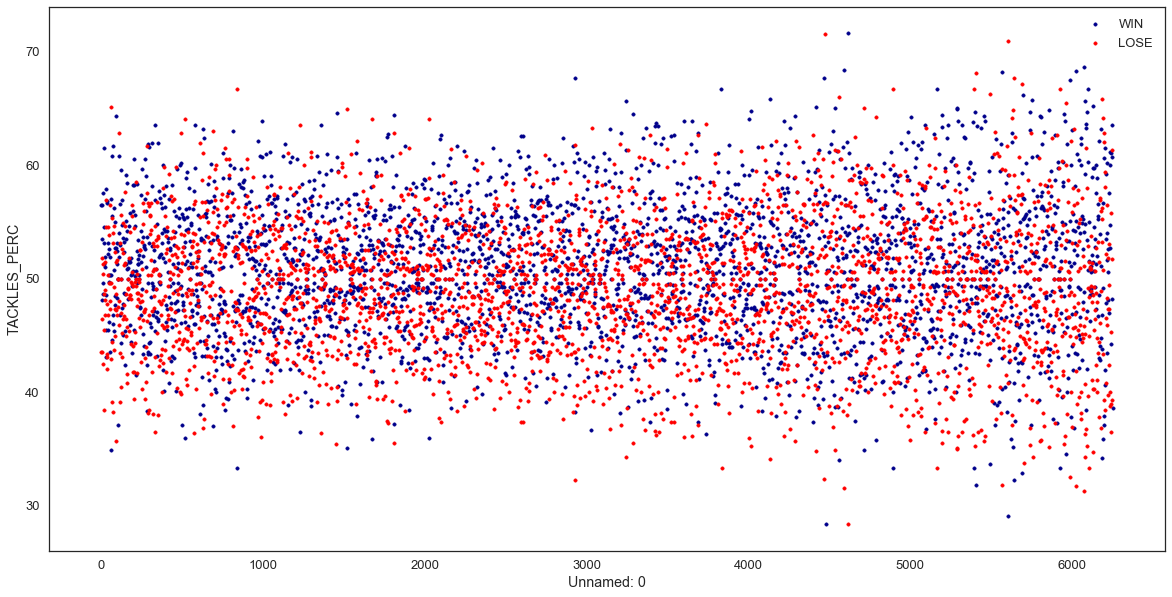

In [127]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TACKLES_PERC", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="TACKLES_PERC", s=12, color='Red', label='LOSE', ax=ax);

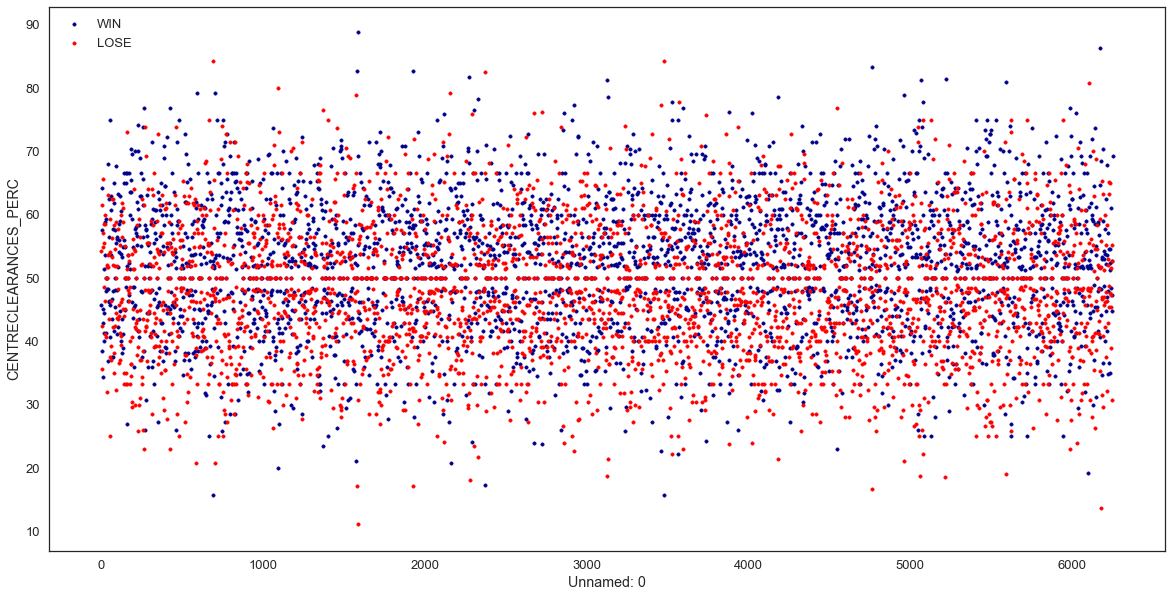

In [123]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="CENTRECLEARANCES_PERC", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="CENTRECLEARANCES_PERC", s=12, color='Red', label='LOSE', ax=ax);

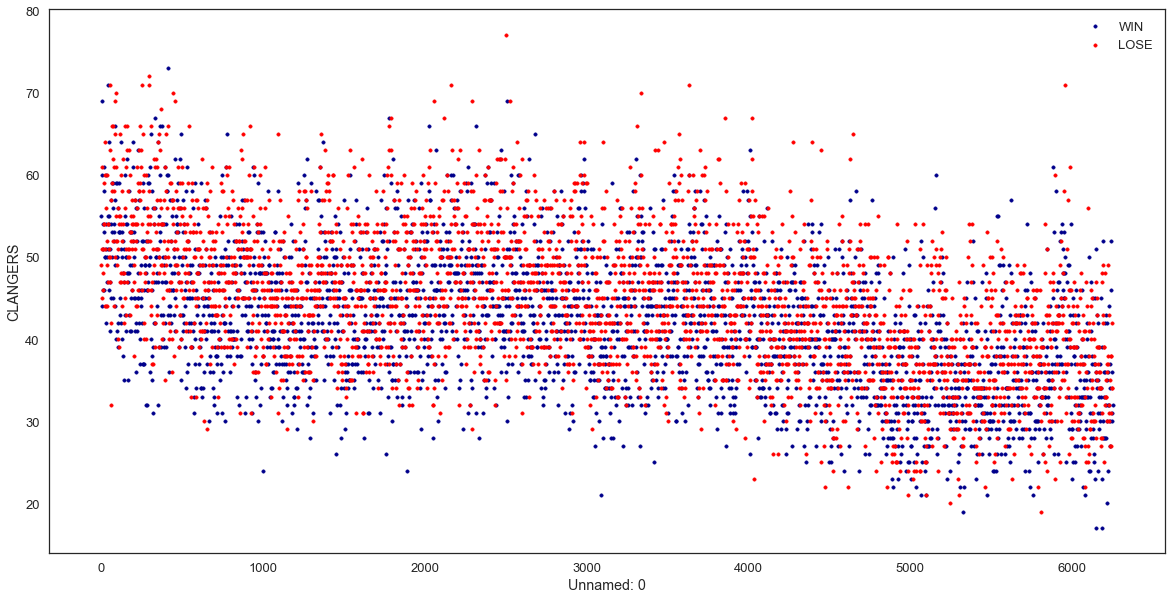

In [113]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="CLANGERS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="CLANGERS", s=12, color='Red', label='LOSE', ax=ax);

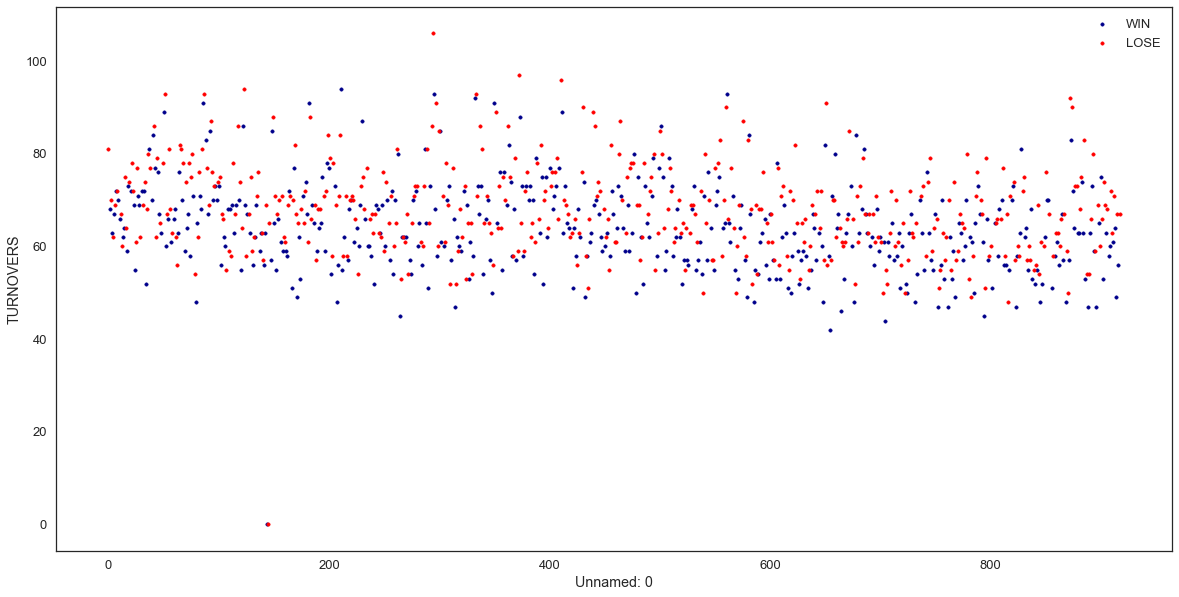

In [118]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TURNOVERS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="TURNOVERS", s=12, color='Red', label='LOSE', ax=ax);

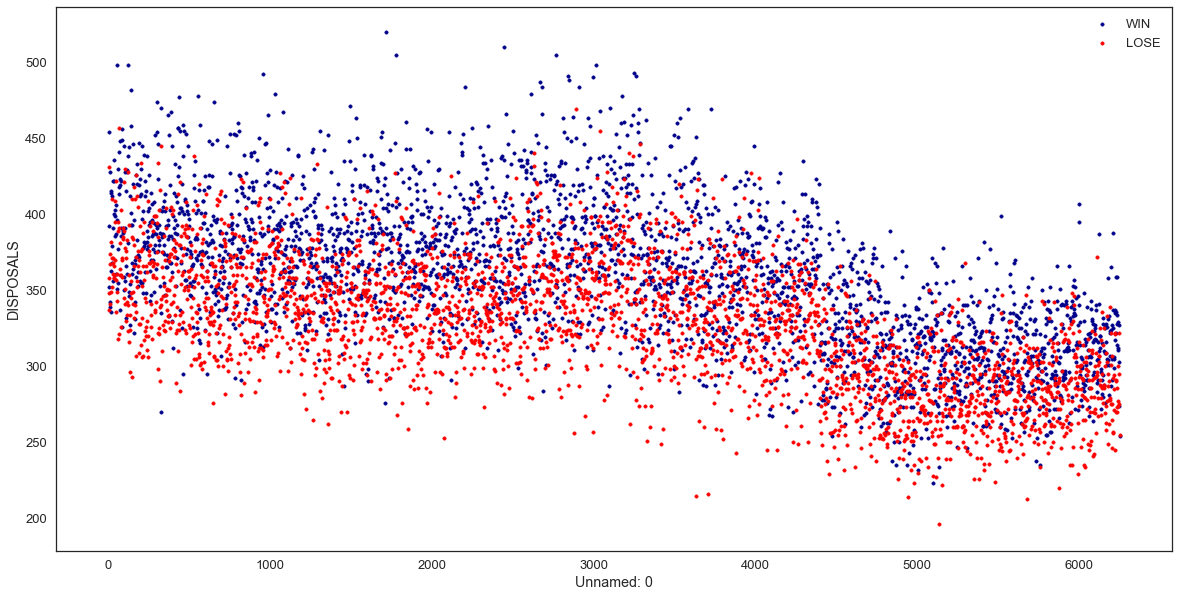

In [98]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="DISPOSALS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="DISPOSALS", s=12, color='Red', label='LOSE', ax=ax);

In [13]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="DISPOSALEFFICIENCY", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="DISPOSALEFFICIENCY", s=12, color='Red', label='LOSE', ax=ax);

NameError: name 'df_win' is not defined

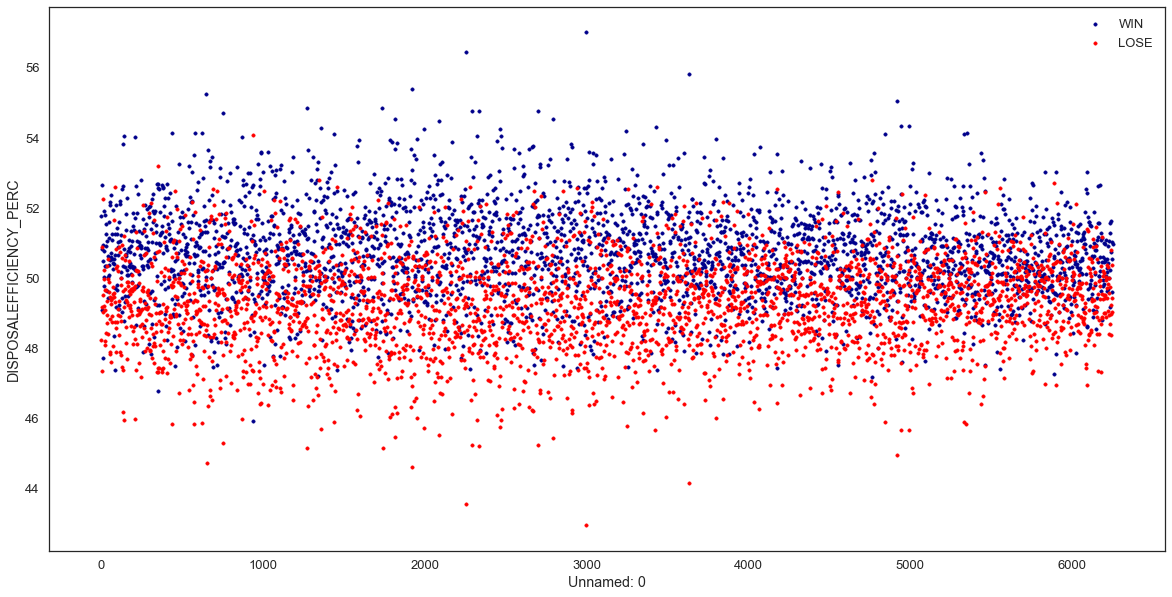

In [120]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="DISPOSALEFFICIENCY_PERC", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="DISPOSALEFFICIENCY_PERC", s=12, color='Red', label='LOSE', ax=ax);

In [12]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TOTALPOSSESSIONS", s=12, color='DarkBlue', alpha= 0.5,  label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="TOTALPOSSESSIONS", s=12, color='Red', alpha= 0.5, label='LOSE', ax=ax);

NameError: name 'df_win' is not defined

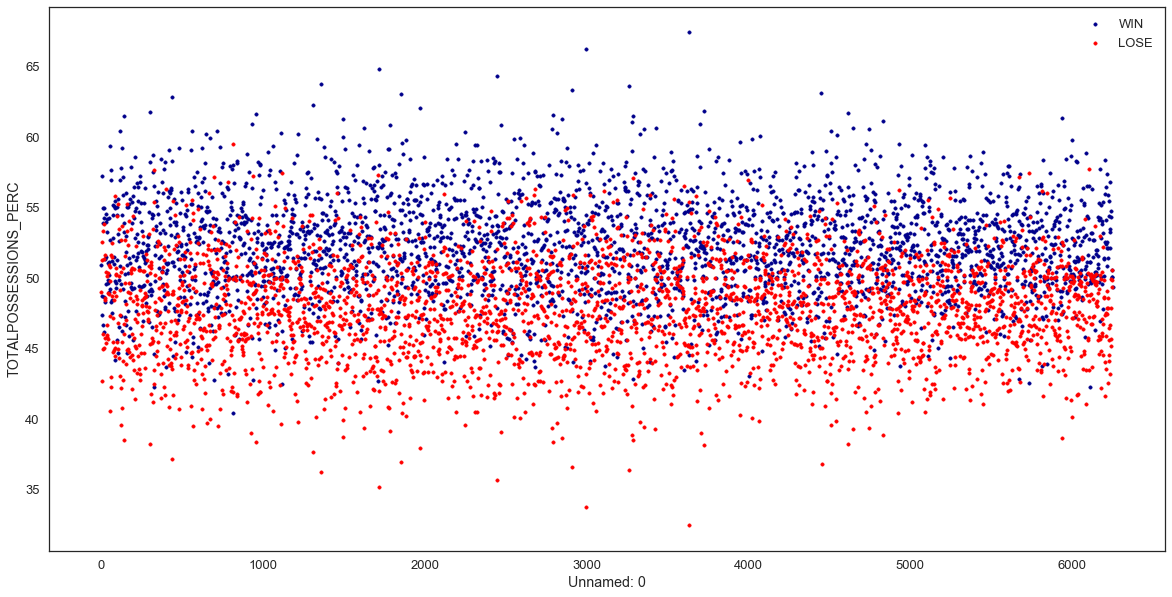

In [119]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TOTALPOSSESSIONS_PERC", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="TOTALPOSSESSIONS_PERC", s=12, color='Red', label='LOSE', ax=ax);

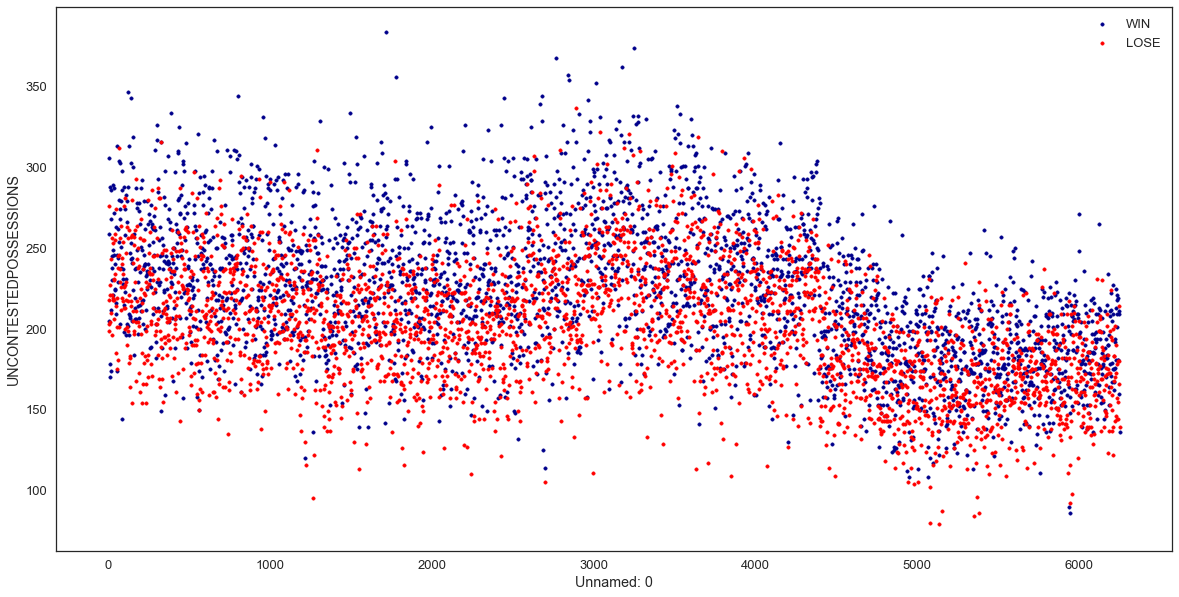

In [92]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="UNCONTESTEDPOSSESSIONS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="UNCONTESTEDPOSSESSIONS", s=12, color='Red', label='LOSE', ax=ax);

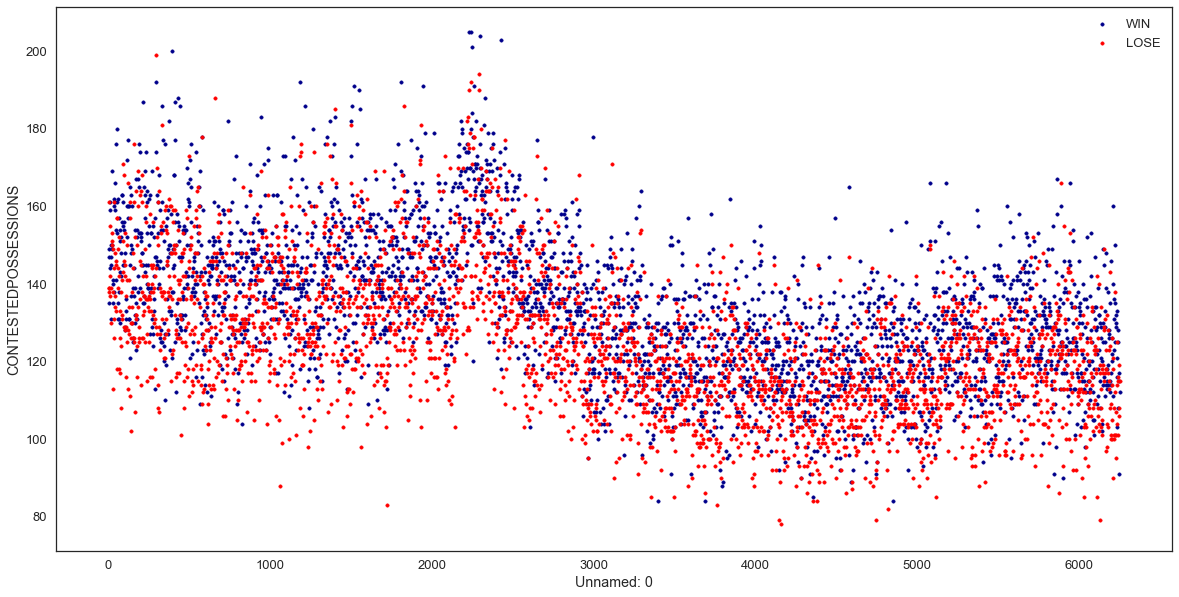

In [124]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS", s=12, color='Red', label='LOSE', ax=ax);

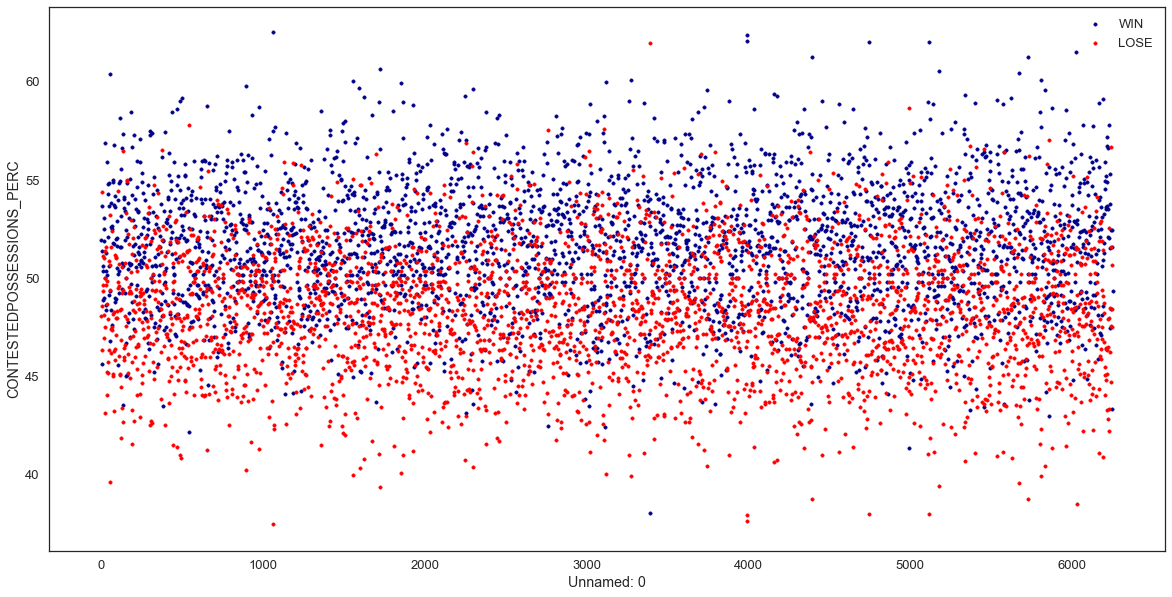

In [125]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS_PERC", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="CONTESTEDPOSSESSIONS_PERC", s=12, color='Red', label='LOSE', ax=ax);

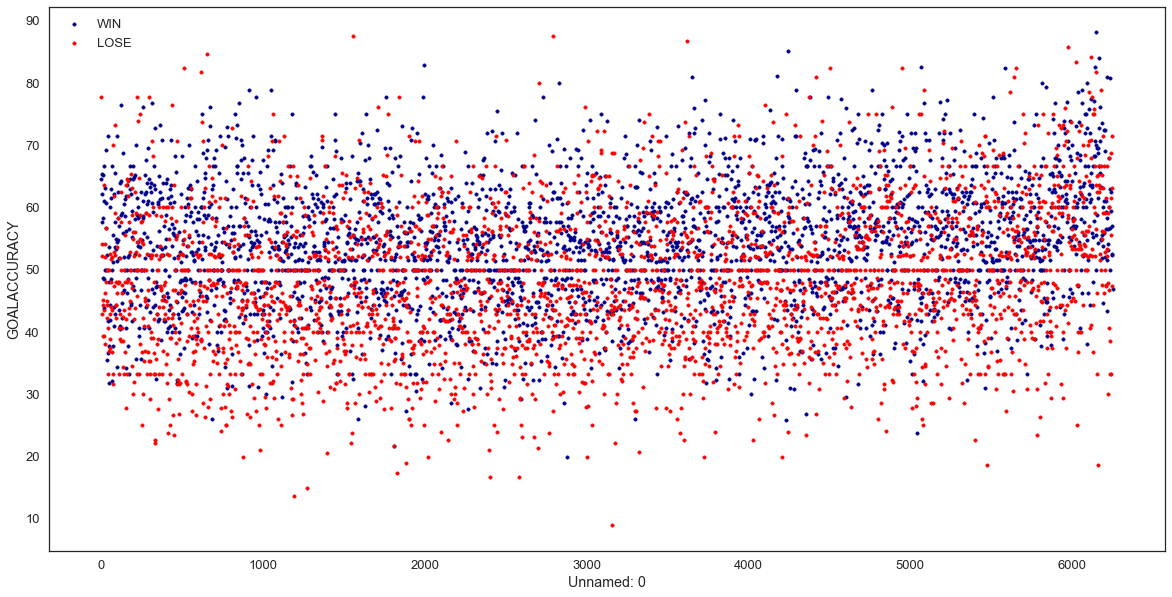

In [96]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="GOALACCURACY", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="GOALACCURACY", s=12, color='Red', label='LOSE', ax=ax);

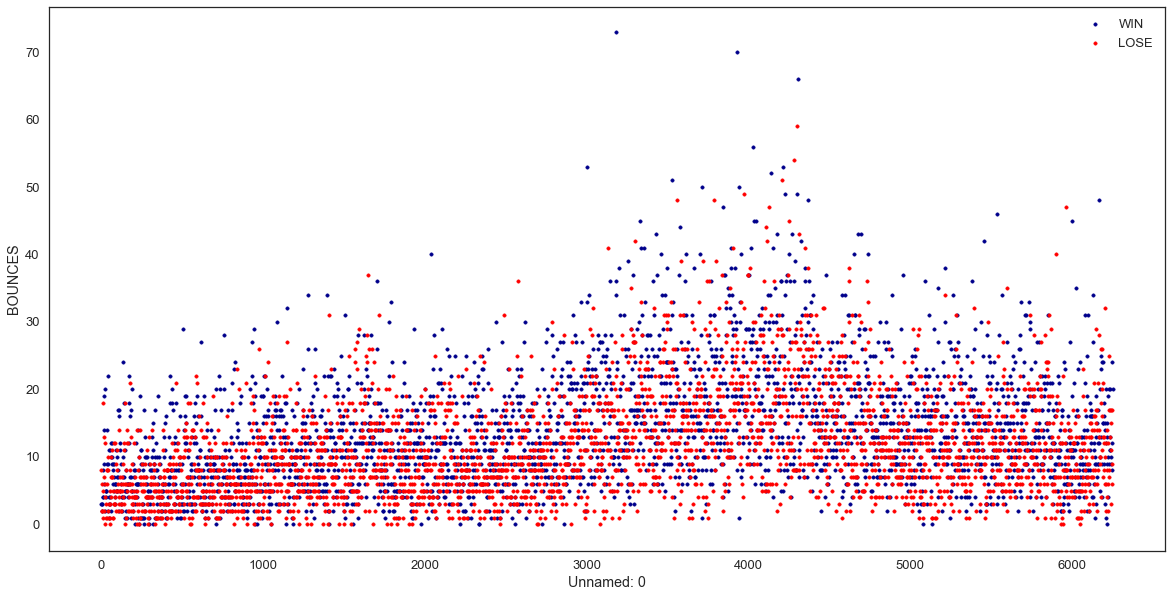

In [106]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="BOUNCES", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="BOUNCES", s=12, color='Red', label='LOSE', ax=ax);

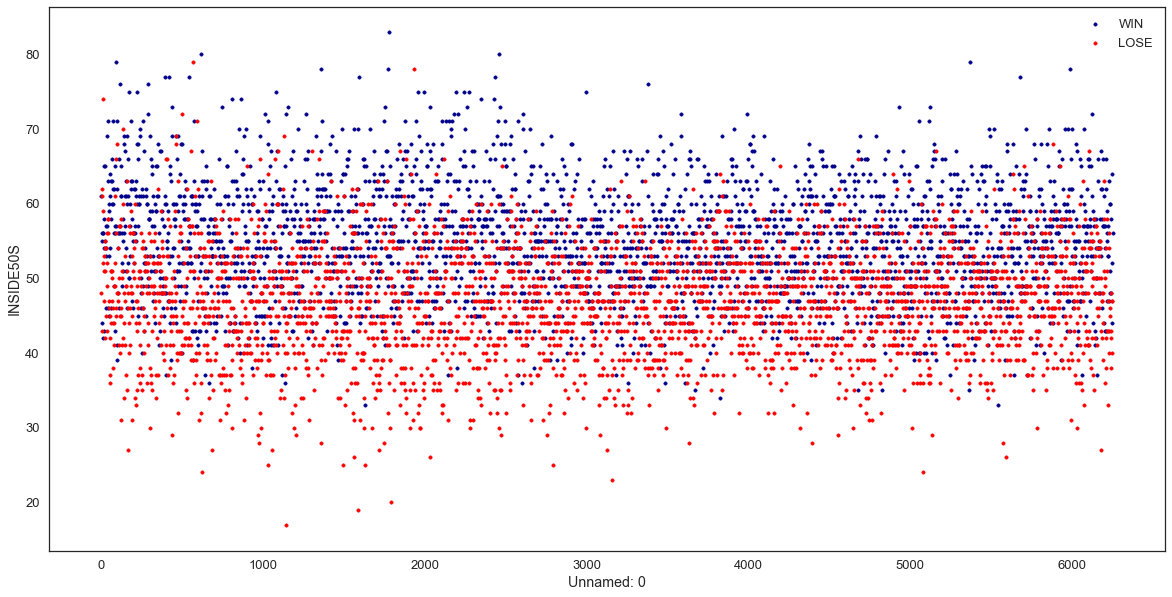

In [108]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="INSIDE50S", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="INSIDE50S", s=12, color='Red', label='LOSE', ax=ax);

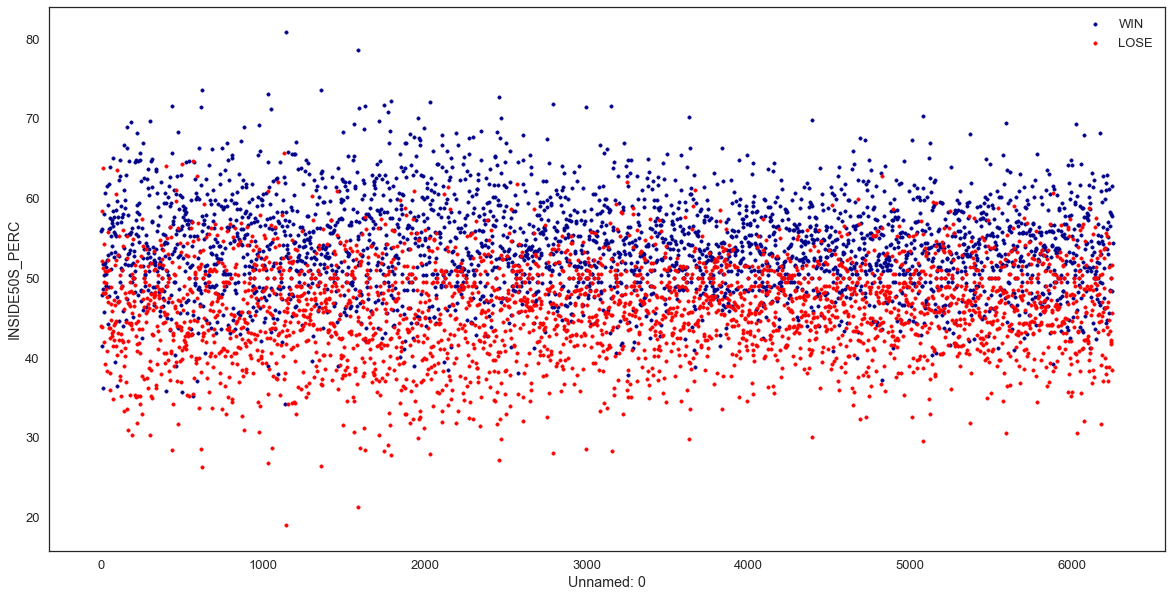

In [121]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="INSIDE50S_PERC", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="INSIDE50S_PERC", s=12, color='Red', label='LOSE', ax=ax);

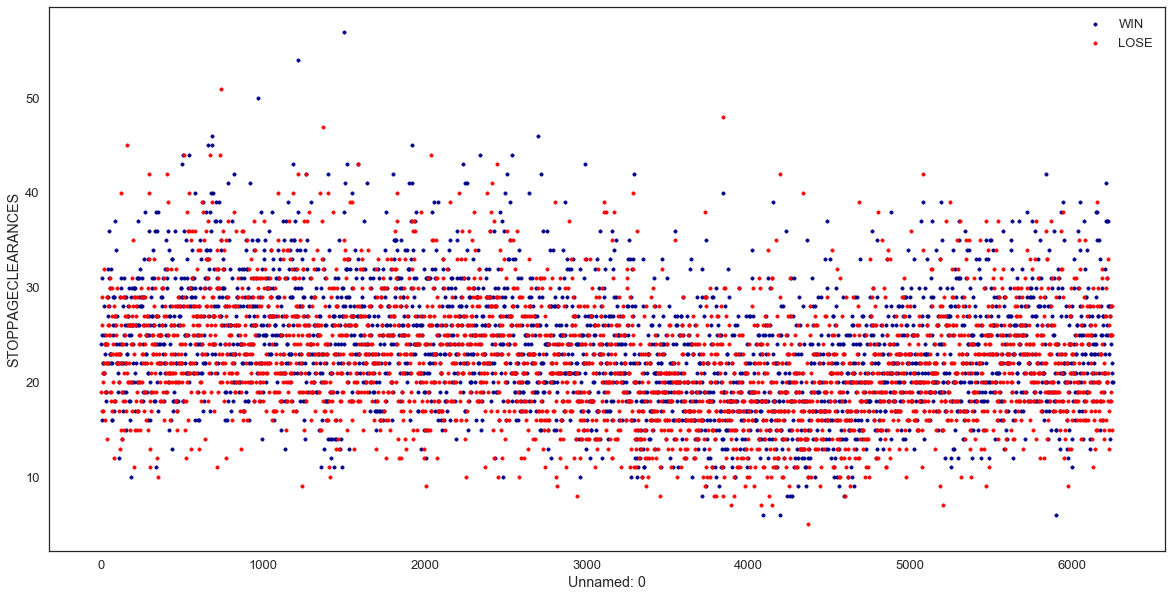

In [109]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="STOPPAGECLEARANCES", s=12, color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="STOPPAGECLEARANCES", s=12, color='Red', label='LOSE', ax=ax);

### WHERE DID THIS DIP HAPPEN?

In [71]:
df.loc[2200]

Unnamed: 0                                2200
BEHINDS                                     10
BOUNCES                                     10
CENTRECLEARANCES                             8
CLANGERS                                    44
CONTESTEDMARKS                              10
CONTESTEDPOSSESSIONS                       153
DISPOSALEFFICIENCY                        64.5
DISPOSALS                                  324
DREAMTEAMPOINTS                           1436
FREESAGAINST                                20
FREESFOR                                    22
GOALACCURACY                              46.4
GOALASSISTS                                  6
GOALEFFICIENCY                             NaN
GOALS                                       13
HANDBALLS                                  149
HITOUTS                                     68
HOME                                      True
INSIDE50S                                   43
INTERCEPTS                                 NaN
INTERCHANGECO

df = df[(df.CONTESTEDPOSSESSIONS) & (df.RESULT == "Win")].groupby(df.MATCH_ID)

In [ ]:
ax = df_win.plot(kind='scatter', x='Unnamed: 0', y="TACKLES", color='DarkBlue', label='WIN' );

df_lose.plot(kind='scatter', x='Unnamed: 0', y="TACKLES", color='Red', label='LOSE', ax=ax);

In [ ]:
df_win = df[df.RESULT == "Win"]

In [ ]:
df_win.head(6000)

### XX AS % WHEN WIN

In [ ]:
df_win["CONTESTEDPOSSESSIONS_PERC"].astype(float).plot()

In [ ]:
df_win["TOTALPOSSESSIONS_PERC"].astype(float).plot()

In [ ]:
match_totals['CONTESTEDPOSSESSIONS'].astype(float).plot()

In [ ]:
df_win['CONTESTEDPOSSESSIONS_PERC'].astype(float).plot()

In [ ]:
match_totals['TOTALPOSSESSIONS'].astype(float).plot()

In [ ]:
match_totals['DISPOSALEFFICIENCY'].astype(float).plot()

In [ ]:
df_win['DISPOSALEFFICIENCY_PERC'].astype(float).plot()

In [ ]:
match_totals['CENTRECLEARANCES'].astype(float).plot()

In [ ]:
df_win['DISPOSALEFFICIENCY_PERC'].astype(float).plot()

In [ ]:
df_win['TACKLES'].astype(float).plot()

In [ ]:
df_win["CENTRECLEARANCES_PERC"].astype(float).plot()

In [ ]:
df_win["INSIDE50S_PERC"].astype(float).plot()

In [ ]:
df["DISPOSALEFFICIENCY_PERC"].astype(float).plot()